# LAPD lab - Machine learning project - Result and comparison

This project aims to predict the GHI two hours in advance locally, from meteo data, date data and webcam images.

We are providing a machine learning model to achieve this task.

This notebook load the best result and compare them.

## Environnement and dataset definition

### Libraries

First, we import all important packages, data, and set the seed (for torch).


In [2]:
#importing packages
import numpy as np
import pandas as pd
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import h5py
import sys
import datetime
import math
import random
import itertools
import pickle

%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.utils.data.sampler import SequentialSampler
from torchvision import transforms, utils

from datetime import datetime

from google.colab import files ### file.download() to download a file from colab instead of right clicking

### Seed definition

In an attempt for reproducibility, we define a torch seed for random processes.

In [3]:
# Set fixed random number seed
torch.manual_seed(3174)

### Mounting the drive
You may need to adjust the path according to your needs.

In [4]:
#Mounting Drive
from google.colab import drive
# # # # This will prompt for authorization.
drive.mount("/content/drive")

## change path to where the folder of the images is
#path = 'drive/MyDrive/Colab Notebooks/CSS 433/data' #antonin
path = 'drive/MyDrive/master/CSS 433/data' #Jade
#path = 'drive/MyDrive/data' #Jade ordi 2
#path = 'drive/MyDrive/CSS 433/data' #Alison

for file in os.listdir(path):
  print(file)

Mounted at /content/drive
time.npy
new_irradiance.xlsx
persistent_level.npy
ground_truth.npy
labels.npy
meteo.xlsx
X.npy
model_D.pt
model_D.pkl


### Creation of the Dataset

This class allows us to load the dataset and access each element individually.

#### GHIDataset

In [5]:
class GHIDataset(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir)).to(torch.float32)

        # Apply the transforms
        if self.transform_images:
            image0 = self.transform_images(image0)
            image1 = self.transform_images(image1)

        if self.transform_label:
            labels = self.transform_label(labels)

        return image0,image1,meteo_data,labels

#### GHIDataset 2

This dataset allows to retrieve multiple indices at once, hence allowing to load consecutive samples.

In [6]:
class GHIDataset2(Dataset):
    """GHI dataset."""

    def __init__(self, root_dir, labels, images, meteo, GHI, time, transform_images=None, transform_label=None, normalise_meteo=False):
        """
        Arguments:
            root_dir  (string) : Path to folder with all the files.
            labels    (string) : Name of the file with labels.
            images    (string) : Name of the file with images.
            meteo     (string) : Name of the file with the meteo data
            GHI       (string) : Name of the file with the GHI (ground truth)
            time      (string) : Name of the file with the time at which the data (meteo and images) has been acquired
            transform_images (callable, optional): Optional transform to be applied to the images.
            transform_label  (callable, optional): Optional transform to be applied to the label.
            transform_meteo  (bool, optional)    : Optional normalisation to be applied to the meteo data.
        """


        self.root_dir = root_dir
        self.labels = torch.from_numpy(np.load(os.path.join(self.root_dir,labels))).to(torch.float32)
        self.images = np.load(os.path.join(self.root_dir,images),mmap_mode='c')

        # Define the transforms to apply to labels or input
        self.transform_images = transform_images
        self.transform_label = transform_label
        self.normalise_meteo = normalise_meteo

        self.GHI =  torch.from_numpy(np.load(os.path.join(path, GHI),allow_pickle=True)).to(torch.float32)

        df = pd.read_excel(os.path.join(self.root_dir, meteo))

        time_image = np.load(os.path.join(self.root_dir, time),allow_pickle=True)

        # Extract day, month, and year using list comprehension
        date = [(dt.day, dt.month, dt.year, dt.hour, dt.minute) if isinstance(dt, datetime) else
         (datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').day,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').month,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').year,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').hour,
          datetime.strptime(dt, '%Y-%m-%d %H:%M:%S').minute)
         for dt in time_image]

        # Transpose the list of tuples using zip
        day_, month_, year_, hour_, minute_ = zip(*date)

        # Convert the individual columns to PyTorch tensors and normalise if required
        if normalise_meteo:
          self.day = torch.tensor(preprocessing.normalize([day_])[0])
          self.month = torch.tensor(preprocessing.normalize([month_])[0])
          self.year = torch.tensor(preprocessing.normalize([year_])[0])
          self.hour = torch.tensor(preprocessing.normalize([hour_])[0])
          self.minute = torch.tensor(preprocessing.normalize([minute_])[0])
          self.air_temp = torch.from_numpy(preprocessing.normalize([df['Air_temp'].values])[0])
          self.wind_speed = torch.from_numpy(preprocessing.normalize([df['Wind_speed'].values])[0])
          self.wind_dir = torch.from_numpy(preprocessing.normalize([df['Wind_dir'].values])[0])
        else:
          self.day = torch.tensor(day_)
          self.month = torch.tensor(month_)
          self.year = torch.tensor(year_)
          self.hour = torch.tensor(hour_)
          self.minute = torch.tensor(minute_)
          self.air_temp = torch.from_numpy(df['Air_temp'].values)
          self.wind_speed = torch.from_numpy(df['Wind_speed'].values)
          self.wind_dir = torch.from_numpy(df['Wind_dir'].values)

    def __len__(self):
        return self.labels.size()[0]

    def __getitem__(self, idx):
        """
        Arguments:
            idx (list or torch.Tensor) : list of two dimension indicating which sample
                                         to get and which webcam.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Import from memory only the data (images, meteo, GHI and time) that we want
        image0 = np.array(self.images[idx,0])
        image1 = np.array(self.images[idx,1])
        labels = self.labels[idx]

        GHI = self.GHI[idx]
        day = self.day[idx]
        month = self.month[idx]
        year = self.year[idx]
        hour = self.hour[idx]
        minute = self.minute[idx]
        air_temp = self.air_temp[idx]
        wind_speed = self.wind_speed[idx]
        wind_dir = self.wind_dir[idx]

        meteo_data = torch.stack((day, month, year, hour, minute, GHI, air_temp, wind_speed, wind_dir),dim=1).to(torch.float32)
        # Apply the transforms
        if self.transform_images:
          image0_transformed = []
          image1_transformed = []
          for image in image0:
            image0_transformed.append(self.transform_images(image))
          for image in image1:
            image1_transformed.append(self.transform_images(image))

        if self.transform_label:
            labels = self.transform_label(labels)

        data = (torch.stack(image0_transformed),torch.stack(image1_transformed),meteo_data,labels)

        return data

Below we load the dataset and transfom the images.

#### Dataset Creation

In [7]:
# Set the desired size of the image
img_size = 100

# The following line creates a transform which converts the np.array to a PIL Image.
# It then resizes the image to img_size x img_size and converts the image to a tensor

transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize(img_size),transforms.ToTensor()])

# Generate the dataset containing all the samples
#ghi_dataset = GHIDataset(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)
ghi_dataset = GHIDataset2(path,'labels.npy','X.npy','meteo.xlsx','ground_truth.npy','time.npy',transform)

#### Separation Functions

In [8]:
def split_at_location(dataset, location = 0, length = 100):
    """
      This function allows to extract the test or validation set at a given location in the dataset
        Arguments:
            location  (int) : position in the dataset where the test/validation set will start
            length    (int) : length of the test/validation set
        """
    # Initialise the indices of the dataset
    dataset_idx = np.arange(len(dataset))
    # Compute start and stop indices of the test/validation set while preventing out-of-range targets
    start_idx = max(0,location)
    end_idx = min(len(dataset),location+length)
    validation_idx = dataset_idx[start_idx:end_idx]

    # Compute the indices of the training set by removing the ones of the test/validation set.
    train_idx = np.concatenate([dataset_idx[:start_idx], dataset_idx[end_idx:]])

    # Return the two sets
    return Subset(dataset, train_idx), Subset(dataset, validation_idx)

def train_val_dataset(dataset,test_split=0.8, val_split=0.2):
    """
      split dataset in train set, validation set, test set
    """

    test_idx, train_idx = train_test_split(list(range(len(dataset))), test_size=test_split,shuffle=False)
    train_idx, val_idx = train_test_split(train_idx,test_size=val_split,shuffle=False)

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

def shuffle(dataset) :
  """
      This function allows to shuffle the data in the given set
  """

  data_idx = np.arange(len(dataset))
  random.shuffle(data_idx)
  #print(data_idx)
  return Subset(dataset, data_idx)


#### Choose our validation set

In [9]:
location1 = 1270
location2 = 4000 - 400
location3 = 7900 - 800

ghi_train, ghi_test1 = split_at_location(ghi_dataset, location1, 400)
ghi_train, ghi_test2 = split_at_location(ghi_train, location2, 400)
ghi_train, ghi_test3 = split_at_location(ghi_train, location3, 400)

ghi_test = ghi_test1 + ghi_test2 + ghi_test3
print("Train set of size      : ", len(ghi_train))
print("Validation set of size : ",len(ghi_test))

# below : in case of only one validation set, no cross validation

#ghi_train ,ghi_val= split_at_location(ghi_train, 0, round(len(ghi_train)*0.10))

#define the loader !
#train_loader = DataLoader(ghi_train, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_train)), batch_size=32, dec = 32))
#test_loader = DataLoader(ghi_test, batch_sampler=SequentialBatchSampler(np.arange(len(ghi_test)), batch_size=32, dec = 32))


Train set of size      :  9493
Validation set of size :  1200


## Definition of dataloaders

Finally we create the dataloader, to iterate on it as we compute each epoch.

We define a custom batch sampler because we need to conserve the order of the samples in each batch. Moreover, we want the stride (dec) between each batch to be customizable and not the batch size. Such that for a dataset = [1,2,3,4,5,6] and a batch size of 3 we get [1,2,3], [2,3,4], [3,4,5], [4,5,6] as batches

#### Sequencer 1

In [10]:
class SequentialBatchSampler:
    def __init__(self, data_source, batch_size, dec):
        self.data_source = data_source
        self.batch_size = batch_size
        self.dec = dec

    def __iter__(self):
      i = 0
      while i <= len(self.data_source)-self.batch_size-1:
        #print(self.data_source[i:i+self.batch_size].dtype)
        yield [self.data_source[i:i+self.batch_size]]
        i += self.dec

#### Sequencer 2

In [11]:
class SequentialBatchSampler2:
    def __init__(self, data_source, batch_size, L,validation = False):
        self.data_source = data_source
        self.batch_size = batch_size
        self.L = L
        self.validation = validation

    def __iter__(self):
      indices = np.arange(len(self.data_source)-self.L)+self.L #if we use the last 4 images, we need to take out the first 4 images
      #note for later -> this is assuming we have continuous train data ! we should use a preprocessing step to look at the continuity
      #to enter only the data when the following 4 ,data is good
      if not self.validation:
        np.random.shuffle(indices)
      batch = []
      for idx in indices:
        sample = self.data_source[idx-self.L:idx]
        batch.append(sample)
        if len(batch) == self.batch_size:
          yield batch
          batch = []

## Load and plot model results

In [22]:
def reload(path_file):

  file_path = os.path.join(path, path_file)
  # Load the dictionary from the file
  with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

  # Retrieve individual lists
  result1 = loaded_data['dataset1']
  result2 = loaded_data['dataset2']
  result3 = loaded_data['dataset3']

  return result1,result2,result3


In [23]:
model = ['model_D.pkl']
name = ['D']

R1 = []
R2 = []
R3 = []

for M in model:
  r1,r2,r3 = reload(M)
  R1.append(r1)
  R2.append(r2)
  R3.append(r3)

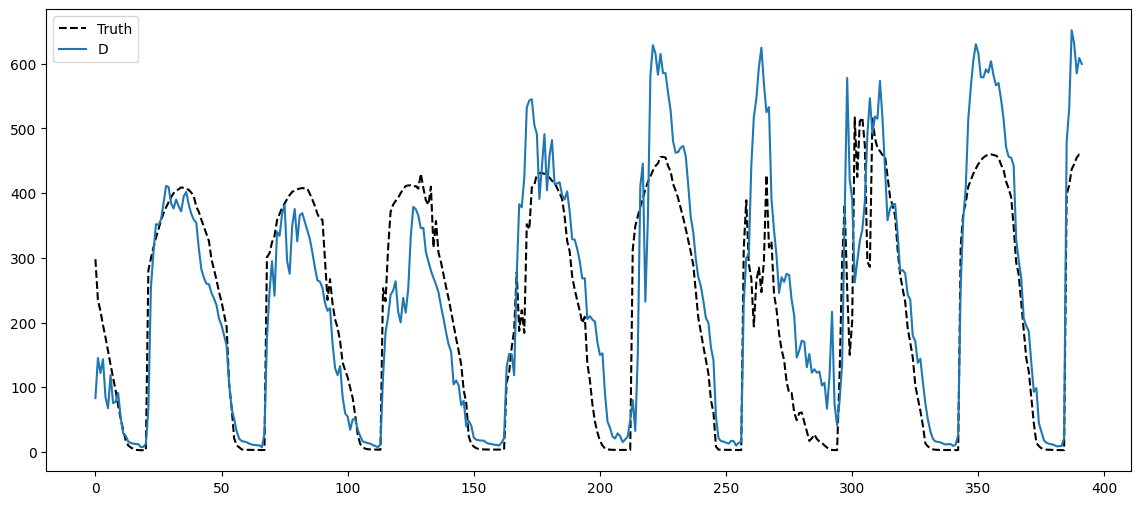

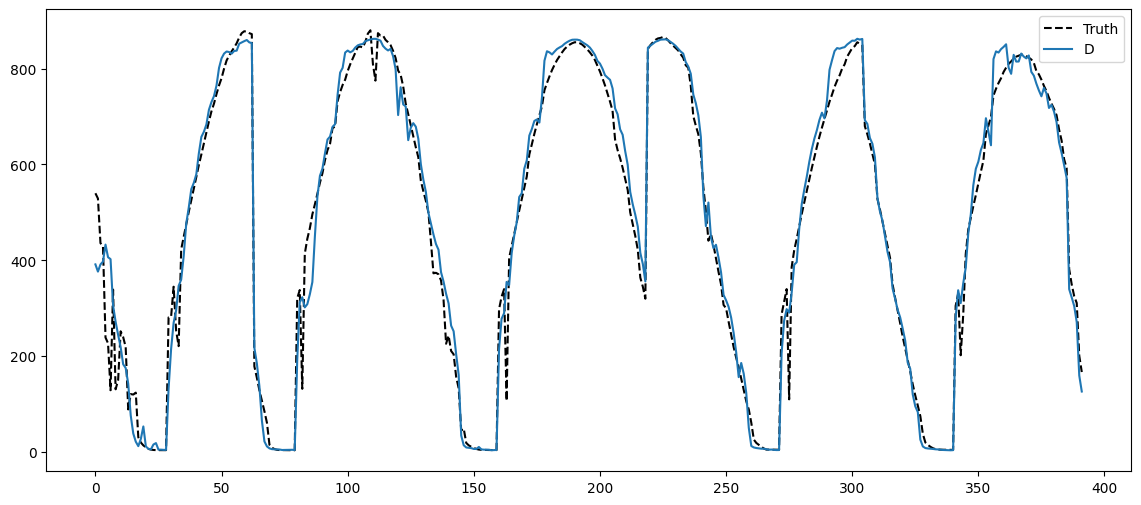

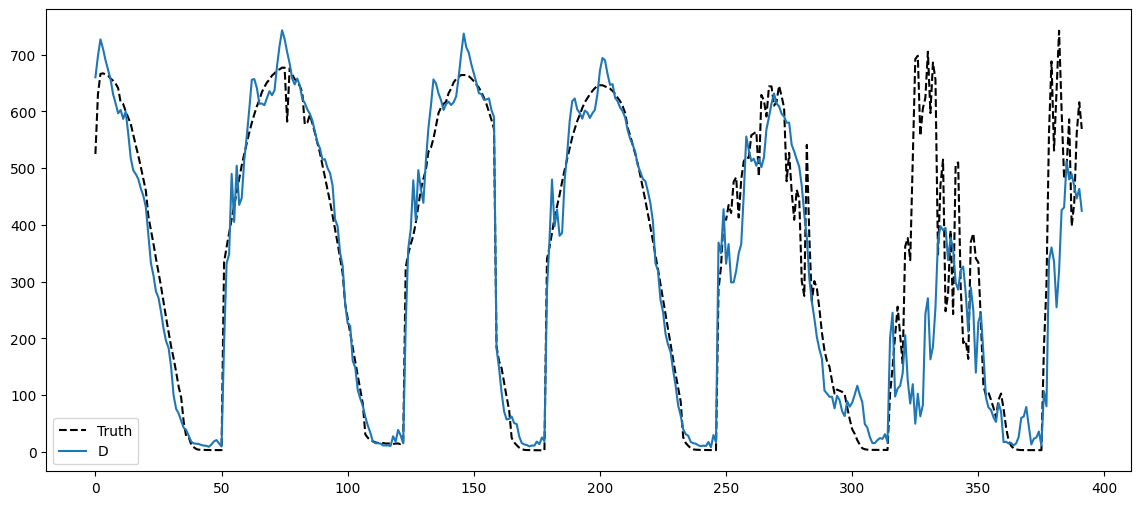

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(ghi_test1, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test1)),L=1,batch_size=8,validation= True))

truth = []
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()
  truth.extend(target[...,-1].tolist())

#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(truth, '--k',label = 'Truth')

for i in range(len(R1)) :
  plt.plot(R1[i], label = name[i])
plt.legend(loc = 'best')
plt.show()

test_loader = DataLoader(ghi_test2, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test2)),L=1,batch_size=8,validation= True))

truth = []
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()
  truth.extend(target[...,-1].tolist())

#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(truth, '--k',label = 'Truth')

for i in range(len(R2)) :
  plt.plot(R2[i], label = name[i])
plt.legend(loc = 'best')
plt.show()


test_loader = DataLoader(ghi_test3, batch_sampler=SequentialBatchSampler2(np.arange(len(ghi_test3)),L=1,batch_size=8,validation= True))

truth = []
for data in test_loader:
  data = list(feature.to(device) for feature in data)
  target = data.pop()
  truth.extend(target[...,-1].tolist())

#### a plot to visualize our predictions vs the true vlaues
plt.figure(figsize=(14,6))
plt.plot(truth, '--k',label = 'Truth')

for i in range(len(R3)) :
  plt.plot(R3[i], label = name[i])
plt.legend(loc = 'best')
plt.show()
